<div class="alert alert-success">
    <h1 align="center">Lesson 6: Language Models Using RNNs</h1>
    <h3 align="center">Deep Learning in Python Workshop (HamYad Lab, 2018)</h3>
    <h5 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h5>
</div>

## Introduction

A **language model** assigns a probability to every sequence of words.

$$P(w_1, w_2,\dots, w_n)=P(w_1)P(w_2|w_1)P(w_3|w_1,w_2) \times \dots \times P(w_n|w_1,w_2, \dots, w_{n-1})$$

### Applications

- **Translation**: We can compare different orderings of words:
<h6 align="center">P(he likes apple) > P(apple likes he)</h6>
<br>
- **Speech Recognition**: We can choose words:
<h6 align="center">P(he likes apple) > P(apple licks he)</h6>

## Libraries

In [77]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import sys
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

#from utils import *
#from data_utils import Vocabulary
#from train_utils import train

from IPython.core.debugger import Pdb  ## DEBUG ##

# setup
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12., 6.)
pdb = Pdb()
use_gpu = torch.cuda.is_available()

In [78]:
## Helper Functions
import re
import spacy
import torch
from torch.autograd import Variable


NLP = spacy.load('en_core_web_sm')


def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)


def detach(x):
    """Wraps hidden states in new tensors, detaching them from their history."""
    if isinstance(x, torch.Tensor):
        return x.detach()
    else:
        return tuple(detach(v) for v in x)

    
    
def tokenizer(text):
    text = re.sub(b'\u200c'.decode("utf-8", "strict"), " ", text)   # replace half-spaces with spaces
    text = re.sub('\n', ' ', text)
    text = re.sub('-', ' - ', text)
    text = re.sub('[ ]+', ' ', text)
    text = re.sub('\.', ' .', text)
    text = re.sub('\،', ' ،', text)
    text = re.sub('\؛', ' ؛', text)
    text = re.sub('\؟', ' ؟', text)
    text = re.sub('\. \. \.', '...', text)
    
    return [w.text for w in NLP.tokenizer(str(text))]

class Vocabulary(object):
    
    def __init__(self):
        self.word2index = {}
        self.index2word = {}
        self.word2count = {}
        self.num_words = 0
        
    def add_word(self, word):
        if not word in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
        
    def add_words(self, words):
        for word in words:
            self.add_word(word)
    
    def __len__(self):
        return self.num_words
    
    

<>:27: SyntaxWarning: invalid escape sequence '\u'
<>:31: SyntaxWarning: invalid escape sequence '\.'
<>:35: SyntaxWarning: invalid escape sequence '\.'
<>:27: SyntaxWarning: invalid escape sequence '\u'
<>:31: SyntaxWarning: invalid escape sequence '\.'
<>:35: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_1660875/2014688387.py:27: SyntaxWarning: invalid escape sequence '\u'
  text = re.sub(b'\u200c'.decode("utf-8", "strict"), " ", text)   # replace half-spaces with spaces
/tmp/ipykernel_1660875/2014688387.py:31: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('\.', ' .', text)
/tmp/ipykernel_1660875/2014688387.py:35: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('\. \. \.', '...', text)


Helper functions

In [79]:
def plot_loss(trn_hist, val_hist):
    plt.plot(trn_hist, label='Training Loss')
    plt.plot(val_hist, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


def tokenize_corpus(corpus_path):
    num_lines = len(open(corpus_path, encoding='utf8').read().split('\n'))
    
    # tokenize corpus
    output = ''
    with open(corpus_path, encoding='utf8') as f:
        for line in tqdm_notebook(f, desc='Tokenizing', total=num_lines):
            tokens = tokenizer(line.strip()) + ['\n']
            output += ' '.join(tokens)
    
    # save tokenized corpus
    tok_corpus_path = corpus_path[:-4] + '_tok.txt'
    with open(tok_corpus_path, 'w', encoding='utf8') as f:
        f.write(output)

## Data

In [80]:
data_dir = '/mnt/home/mnikzad/ML_Practice/Language-Model/data'
output_dir = f'{data_dir}'

train_data = f'{data_dir}/fa.ghomshei.txt'
train_data_tok = train_data[:-4] + '_tok.txt'

### Tokenizing

In [81]:
tokenize_corpus(train_data)

text = open(train_data, encoding='utf8').read().split('\n')[6000:6010]
print(text)

print('\n\nAfter Tokenizing:\n\n')
print(tokenizer('\n'.join(text)))

/tmp/ipykernel_1660875/2266349051.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(f, desc='Tokenizing', total=num_lines):


Tokenizing:   0%|          | 0/6250 [00:00<?, ?it/s]

['در صورتی که مانند آن شهری (در استحکام و بزرگی و تنعّم) در بلاد عالم ساخته نشده بود.', 'و نیز به قوم ثمود که در دل آن وادی سنگ را شکافته و کاخها بر خود از سنگ می\u200cساختند چه کیفر سخت داد؟', 'و نیز فرعون (و فرعونیان) را که صاحب قدرت و سپاه بسیار بود (چگونه به دریای هلاک غرق نمود).', 'آنان که در روی زمین ظلم و طغیان کردند.', 'و بسیار فساد و فتنه انگیختند.', 'تا آنکه خدای تو بر آنها تازیانه عذاب پی در پی فرستاد.', 'خدای تو البته در کمینگاه (ستمکاران) است.', 'اما انسان (کم ظرف ضعیف بی صبر) چون خدا او را برای آزمایش و امتحان کرامت و نعمتی بخشد در آن حال (مغرور ناز و نعمت شود و) گوید: خدا مرا عزیز و گرامی داشت.', 'و چون او را باز برای آزمودن تنگ روزی کند (دلتنگ و غمین شود و) گوید: خدا مرا خوار گردانید.', 'چنین نیست بلکه (به گناه بخل و طمع خوار شوید چون) هرگز یتیم نوازی نکنید.']


After Tokenizing:


['در', 'صورتی', 'که', 'مانند', 'آن', 'شهری', '(', 'در', 'استحکام', 'و', 'بزرگی', 'و', 'تنعّم', ')', 'در', 'بلاد', 'عالم', 'ساخته', 'نشده', 'بود', '.', 'و', 'نیز', 'به', 'قوم', 'ثمود', 'که', '

### Statistics

In [82]:
def cal_stats(corpus_path):
    # collect the number of tokens used in each sentence of the corpus in a list
    lengths = [len(s.split(' ')) for s in open(corpus_path, encoding='utf8').read().split('\n')]
    
    # compute stats
    total = sum(lengths)
    mean = np.mean(lengths)
    std = np.std(lengths)
    
    # print stats
    print('Total words in the corpus = {}\n'.format(total))
    print('Mean = {:.2f}'.format(mean))
    print('Std  = {:.2f}'.format(std))
    print('95% confidence interval = [{:.2f}, {:.2f}]'.format(mean-2*std, mean+2*std))
    
    # plot histogram
    plt.hist(lengths, bins=20)
    plt.show()

Total words in the corpus = 189709

Mean = 30.35
Std  = 21.67
95% confidence interval = [-12.98, 73.68]


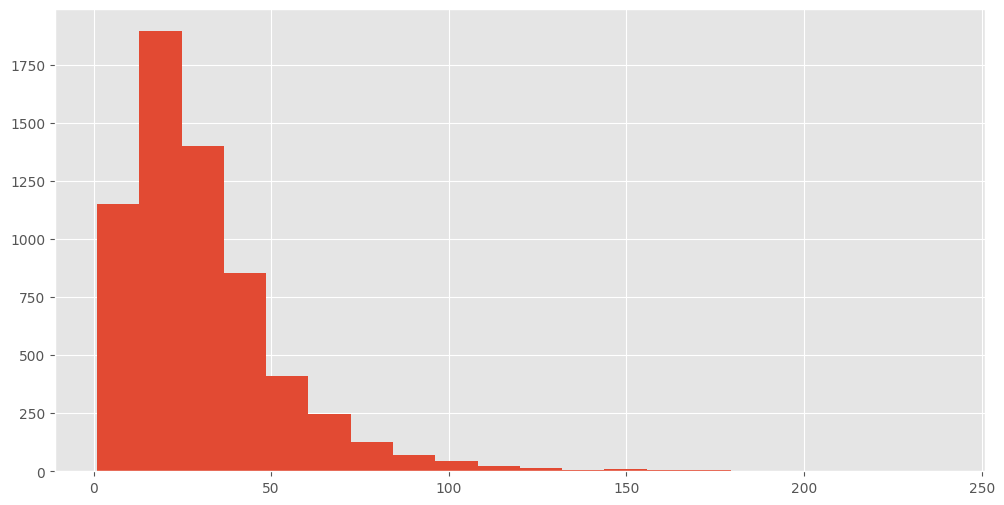

In [83]:
cal_stats(train_data)

### Corpus

In [84]:
class Corpus(object):
    
    def __init__(self, corpus_path='data/train.txt'):
        self.vocabulary = Vocabulary()
        self.corpus_path = corpus_path
        self.num_sentences = len([line for line in open(corpus_path, encoding='utf8')])
    
    def get_data(self, max_vocab=30000, min_count=3, batch_size=20, split_ratio=0.2):
        
        # First pass: add words to the vocabulary
        trn_tokens, val_tokens = [], []
        with open(self.corpus_path, encoding='utf8') as f:
            for line in tqdm_notebook(f, desc='Building Vocab...', total=self.num_sentences):
                tokens = line.split() + ['<EOS>']
                if len(line) <= 10: continue
                if random.random() < split_ratio:
                    val_tokens += tokens
                else:
                    trn_tokens += tokens
        
        counter = Counter(trn_tokens + val_tokens)
        
        # sort tokens according to their frequencies in the Corpus
        vocabs = [(w, c) for (w, c) in counter.most_common(max_vocab) if c >= min_count]
        
        for i, (word, count) in enumerate(vocabs):
            self.vocabulary.word2index[word] = i
            self.vocabulary.word2count[word] = count
            self.vocabulary.index2word[i] = word
            self.vocabulary.num_words += 1
        self.vocabulary.add_word('<UNK>')
        
        
        # Second pass: Tokenize file content
        UNK_TOKEN = self.vocabulary.word2index['<UNK>']
        
        # train ids
        trn_ids = torch.LongTensor(len(trn_tokens))
        for idx, token in enumerate(trn_tokens):
            if token in self.vocabulary.word2index:
                trn_ids[idx] = self.vocabulary.word2index[token] 
            else:
                trn_ids[idx] = UNK_TOKEN
        
        # validation ids
        val_ids = torch.LongTensor(len(val_tokens))
        for idx, token in enumerate(val_tokens):
            if token in self.vocabulary.word2index:
                val_ids[idx] = self.vocabulary.word2index[token] 
            else:
                val_ids[idx] = UNK_TOKEN
        
        num_batches = trn_ids.size(0) // batch_size
        trn_ids = trn_ids[: num_batches * batch_size]
        
        num_batches = val_ids.size(0) // batch_size
        val_ids = trn_ids[: num_batches * batch_size]

        return trn_ids.view(batch_size, -1), val_ids.view(batch_size, -1)

### Hyper-parameters

In [85]:
max_vocab = 30000
min_count = 1

# LSTM hyper-parameters
embed_size = 1500
hidden_size = 1500
num_layers = 2

# Training hyper-parameters
num_epochs = 40
batch_size = 50
seq_length = 60
learning_rate = 0.001

### Load Data

In [86]:
corpus = Corpus(train_data_tok)
trn_ids, val_ids = corpus.get_data(max_vocab, min_count, batch_size)
vocab_size = len(corpus.vocabulary)

# save vocabs and ids
pickle.dump(corpus.vocabulary, open(f'{data_dir}/vocab.pkl', 'wb'))
np.save(f'{data_dir}/trn_ids.npy', trn_ids.view(-1).numpy())
np.save(f'{data_dir}/val_ids.npy', val_ids.view(-1).numpy())

/tmp/ipykernel_1660875/264560081.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(f, desc='Building Vocab...', total=self.num_sentences):


Building Vocab...:   0%|          | 0/6249 [00:00<?, ?it/s]

In [10]:
# corpus = Corpus(train_data)
# corpus.vocabulary = pickle.load(open(f'{data_dir}/vocab.pkl', 'rb'))

# trn_ids = torch.LongTensor(np.load(f'{data_dir}/trn_ids.npy'))
# trn_ids = trn_ids[: trn_ids.size(0) // batch_size * batch_size]
# trn_ids = trn_ids.view(batch_size, -1)

# val_ids = torch.LongTensor(np.load(f'{data_dir}/val_ids.npy'))
# val_ids = val_ids[: val_ids.size(0) // batch_size * batch_size]
# val_ids = val_ids.view(batch_size, -1)

In [87]:
vocab_size = len(corpus.vocabulary)
print(vocab_size)
print(trn_ids.size())
print(val_ids.size())

10016
torch.Size([50, 3660])
torch.Size([50, 900])


In [76]:
most_commons = [(w, c) for (w, c) in corpus.vocabulary.word2count.items()][:10016]

for w, c in most_commons:
    print(w, c)

و 17213
به 7191
( 7168
) 7156
که 7041
. 6315
<EOS> 6243
را 5911
از 5146
، 3729
خدا 3434
در 3421
آن 2770
می 2679
است 2520
بر 2345
شما 2208
ما 1832
آنها 1717
این 1698
او 1522
خود 1512
هر 1282
تو 1187
: 1182
با 1173
؟ 1002
آنان 989
تا 942
ای 939
برای 896
پس 885
همه 837
من 831
هم 806
ایمان 782
اگر 768
هیچ 632
کنند 620
خدای 580
کنید 566
کند 562
حق 560
باز 549
بود 544
مردم 543
اهل 540
آیا 540
یا 530
کرد 528
زمین 516
عذاب 511
نمی 510
جز 508
روز 501
چون 500
بسیار 483
راه 476
کافران 472
خواهد 452
چه 446
آنکه 446
کردند 427
کس 424
رسول 423
آنچه 412
خلق 408
هرگز 405
گاه 404
گفت 396
آیات 391
البته 378
نیست 373
بی 361
سخت 359
شود 348
شد 347
عالم 340
کرده 336
کار 334
پیش 333
بگو 328
قوم 325
حال 314
گفتند 314
قیامت 311
هدایت 308
همانا 305
کتاب 299
آگاه 298
شدند 284
دیگر 277
کردیم 271
دنیا 266
قرآن 265
باشد 261
نیز 260
گویند 259
روزی 259
شوند 255
سوی 254
روی 254
موسی 252
خدایی 251
دو 245
دوزخ 244
خداست 239
کافر 233
مانند 230
یاد 228
آتش 228
نه 225
چنین 222
مرا 221
حقیقت 218
شوید 215
! 209
وعده 208
رحمت

## LSTM For Language Modeling

<img src='imgs/deep-rnns.png' width='90%'/>

In [88]:
class LSTM_LM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, drop=0.35, tie=True):
        super(LSTM_LM, self).__init__()
        
        if tie:
            embed_size = hidden_size
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
            
        self.dropout = nn.Dropout(drop)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.35)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        if tie:
            # Use the same weights both for embedding and classification
            self.fc.weight.data = self.embedding.weight.data
            
        self.init_weights()
        
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        
    def init_hidden(self, batch_size):
        return (to_var(torch.zeros(self.num_layers, batch_size, self.hidden_size)),
                to_var(torch.zeros(self.num_layers, batch_size, self.hidden_size)))
        
    def forward(self, x, hidden):
        # embed word ids to vectors
        x = self.embedding(x)
        x = self.dropout(x)  # DROPOUT
        
        # forward RNN step
        x, hidden = self.lstm(x, hidden)
        x = self.dropout(x)  # DROPOUT
        
        # reshape output to (bs * seq_length, hidden_size)
        x = x.contiguous().view(x.size(0) * x.size(1), x.size(2))
        
        # decode hidden states of all time steps
        x = self.fc(x)
        
        return x, hidden
    
    def save(self, epoch, loss, save_to=output_dir):
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        filename = output_dir + '/lm-quran-epoch-{}-em-{}-hi-{}-nl-{}-{:.2f}-{:.2f}.pth'.format(
            epoch, self.embed_size, self.hidden_size, self.num_layers, loss, np.exp(loss))
        torch.save(self.state_dict(), filename)

#### Tie Weights (Embedding and classification)

<h6>Idea:</h6> Reuse Embeddings for Classification, which greatly reduces the number of trainable parameters:
- [Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling (Inan et al. 2016)](https://arxiv.org/pdf/1611.01462.pdf)

### Define model

In [89]:
# model
model = LSTM_LM(vocab_size, embed_size, hidden_size, num_layers, drop=0.65)
if use_gpu:
    model = model.cuda()

# loss function
criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion = criterion.cuda()
    
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

### Training

In [90]:

def train_epoch(epoch, model, trn_ids, 
                criterion, optimizer, scheduler, 
                num_epochs, batch_size, seq_length):
    
    model.train()
    scheduler.step()
    states = model.init_hidden(batch_size)
    num_batches = trn_ids.size(1) // seq_length    
    trn_loss = 0.0
    trn_acc = 0.0
    
    for i in range(0, trn_ids.size(1) - seq_length, seq_length):
        inputs = to_var(trn_ids[:, i: i + seq_length])
        targets = to_var(trn_ids[:, (i + 1): (i + 1) + seq_length].contiguous())
                
        # Forward
        states = detach(states)
        outputs, states = model(inputs, states)
        
        # accuracy
        _, predictions = torch.max(outputs, dim=1)
        acc = torch.mean((predictions == targets.view(-1)).float())
        trn_acc = (trn_acc * i + acc.item()) / (i + 1) 
        
        # loss
        loss = criterion(outputs, targets.view(-1))
        trn_loss = (trn_loss * i + loss.item()) / (i + 1)  
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.3)
        optimizer.step()
        
        # report
        step = (i + 1) // seq_length
        sys.stdout.flush()
        sys.stdout.write('\rTraining: Epoch [%d/%d], Step [%d/%d], Loss: %.3f, Perp: %.2f, Acc: %-15.2f' % 
              (epoch + 1, num_epochs, step + 1, num_batches, trn_loss, np.exp(trn_loss), trn_acc))
    
    return trn_loss


def validate_epoch(epoch, model, val_ids, criterion, 
                   num_epochs, batch_size, seq_length):
    
    model.eval()
    states = model.init_hidden(batch_size)
    num_batches = val_ids.size(1) // seq_length        
    val_loss = 0.0
    val_acc = 0.0
    
    for i in range(0, val_ids.size(1) - seq_length, seq_length):
        inputs = to_var(val_ids[:, i: i + seq_length], volatile=True)
        targets = to_var(val_ids[:, (i + 1): (i + 1) + seq_length].contiguous())
                
        # Forward
        states = detach(states)
        outputs, states = model(inputs, states)
        
        # accuracy
        _, predictions = torch.max(outputs, dim=1)
        acc = torch.mean((predictions == targets.view(-1)).float())
        val_acc = (val_acc * i + acc.item()) / (i + 1) 
        
        # loss
        loss = criterion(outputs, targets.view(-1))
        val_loss = (val_loss * i + loss.item()) / (i + 1)  
                
        # report
        step = (i + 1) // seq_length
        sys.stdout.flush()
        sys.stdout.write('\rValidation: Epoch [%d/%d], Step [%d/%d], Loss: %.3f, Perp: %.2f, Acc: %-15.2f' % 
              (epoch + 1, num_epochs, step + 1, num_batches, val_loss, np.exp(val_loss), val_acc))
        
    return val_loss


def train(model, trn_ids, val_ids, 
          criterion, optimizer, scheduler, 
          num_epochs, batch_size, seq_length):
    
    best_loss = float('Inf')
    best_wgts = None
    
    trn_hist, val_hist = [], []

    for epoch in range(num_epochs):

        trn_loss = train_epoch(epoch, model, trn_ids, 
                               criterion, optimizer, scheduler, 
                               num_epochs, batch_size,  seq_length)
        
        val_loss = validate_epoch(epoch, model, val_ids, criterion, 
                                  num_epochs, batch_size, seq_length)
        
        trn_hist.append(trn_loss)
        val_hist.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_wgts = model.state_dict().copy()
            model.save(epoch, val_loss)
    
    # load best model weights
    model.load_state_dict(best_wgts)
    return trn_hist, val_hist

In [59]:
hist = train(model, trn_ids, val_ids, 
             criterion, optimizer, scheduler, 
             20, batch_size, seq_length)

Training: Epoch [1/20], Step [1/60], Loss: 0.539, Perp: 1.71, Acc: 0.85           

/tmp/ipykernel_1660875/4028616520.py:32: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.3)


Validation: Epoch [1/20], Step [1/15], Loss: 0.516, Perp: 1.68, Acc: 0.90           

/tmp/ipykernel_1660875/2014688387.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


Validation: Epoch [20/20], Step [15/15], Loss: 0.484, Perp: 1.62, Acc: 0.91           

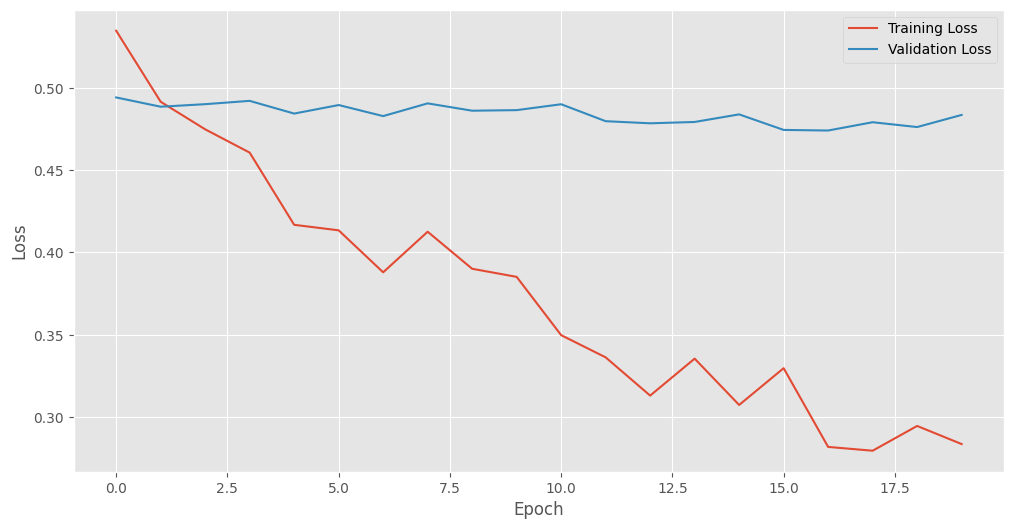

In [60]:
plot_loss(*hist)

In [91]:
torch.save(model.state_dict(), 'quran-lm.pth')

### Sampling

<h6>Algorithm:</h6>
1. **Initialize** the LSTM state (`h`, `c`) with zeros.

2. Pick a **random word** from vocabulary as the seed.

3. while number of generated samples is less than the desired:
 
 3.1 **Feed** the LSTM using the word generated from previous time-step.
 
 3.2 Perform **forward computations** to create the probabilty distribution vector for vocabularies.
 
 3.3 Pick a **random word** from vocabulary according to the probabilty distribution from LSTM.

<img src='imgs/rnn-sampling.png' width='90%'/>

#### Multinomial distribution

In [92]:
N = 1000
p = torch.FloatTensor([0.5, 0.25, 0.15, 0.10])
# p = torch.FloatTensor([50, 25, 15, 10])

counter = Counter()

# Draw N samples
for _ in range(N):
    sample = torch.multinomial(p, num_samples=1, replacement=True)[0]
    counter[sample] += 1
    
# print samples and their counts
for sample, count in counter.most_common():
    print("{:d}: {:2d}".format(sample, count))

1:  1
2:  1
3:  1
0:  1
2:  1
0:  1
2:  1
0:  1
0:  1
1:  1
1:  1
0:  1
0:  1
1:  1
1:  1
1:  1
1:  1
0:  1
0:  1
1:  1
2:  1
1:  1
0:  1
0:  1
1:  1
0:  1
0:  1
0:  1
3:  1
2:  1
1:  1
0:  1
0:  1
0:  1
3:  1
1:  1
2:  1
0:  1
0:  1
0:  1
0:  1
1:  1
0:  1
0:  1
1:  1
0:  1
2:  1
0:  1
0:  1
0:  1
2:  1
0:  1
0:  1
0:  1
0:  1
1:  1
0:  1
3:  1
2:  1
1:  1
0:  1
1:  1
3:  1
0:  1
0:  1
3:  1
0:  1
0:  1
1:  1
0:  1
1:  1
0:  1
0:  1
0:  1
1:  1
2:  1
0:  1
1:  1
0:  1
0:  1
0:  1
1:  1
0:  1
0:  1
0:  1
0:  1
0:  1
1:  1
1:  1
2:  1
1:  1
1:  1
0:  1
1:  1
0:  1
1:  1
0:  1
2:  1
1:  1
0:  1
0:  1
0:  1
0:  1
0:  1
0:  1
0:  1
0:  1
1:  1
0:  1
1:  1
1:  1
2:  1
3:  1
0:  1
1:  1
3:  1
1:  1
2:  1
1:  1
2:  1
3:  1
0:  1
0:  1
0:  1
1:  1
0:  1
1:  1
1:  1
0:  1
0:  1
3:  1
1:  1
0:  1
0:  1
0:  1
1:  1
0:  1
1:  1
1:  1
0:  1
1:  1
1:  1
3:  1
0:  1
0:  1
1:  1
3:  1
1:  1
2:  1
1:  1
0:  1
0:  1
2:  1
0:  1
1:  1
1:  1
0:  1
0:  1
0:  1
0:  1
0:  1
0:  1
0:  1
1:  1
0:  1
1:  1
0:  

In [93]:
def get_sample(model, sample_len):
    model.eval()
    sample = ''
    state = model.init_hidden(1)

    # select a random word id to start sampling
    probs = torch.ones(vocab_size)
    inp = to_var(torch.multinomial(probs, num_samples=1).unsqueeze(1), volatile=True)

    for i in tqdm_notebook(range(sample_len)):
        output, state = model(inp, state)

        # Sample an id
        probs = output.squeeze().data.exp().cpu()
        word_id = torch.multinomial(probs, 1)[0]

        # Feed sampled word id to next time step
        inp.data.fill_(word_id)

        # write to file
        #word = corpus.vocabulary.index2word[word_id]
        word_id_scalar = word_id.item()  # Convert tensor to scalar
        word = corpus.vocabulary.index2word[word_id_scalar]  # Access dictionary with scalar key

        if word == '<EOS>':
            sample += '\n'
        else:
            sample += ' ' + word
    
    return sample

In [95]:
sample = get_sample(model, 300)
print(sample)

/tmp/ipykernel_1660875/2014688387.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
/tmp/ipykernel_1660875/836533385.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(sample_len)):


  0%|          | 0/300 [00:00<?, ?it/s]

 نترسند طلاقی لنگ روزشان نایل امورم پاهایشان تعقل فوجی بافتند طول جهانی مادرزاد نیافتید مطلوب نجس خودپسندی عفیفه بتوانیم گدازنده سفرهای کبری جابر قطره ویران عیسیِ عجبی سرخ زکات رجس صورت ساق پاکدل گرویدید چشم نصایح کدو علوی گناهشان بزرگ داران معارف پیام مخارجی غل شهرها خران متوحش انقلابات سیاهش گزارید مسافر قعر وحشی نوحید درست حمله محنتش اسحاق توالد بگرداند معنای العین ثبات لام عمران حاجتی هاتان فرمانبران بیامرزد دیوار گردن محبت چو سبکی اعطای خواند باریم خبرند پوشاندن رنگارنگ تکذیبها لنگان معاشران اله کلیدهای فرستادی اندازید مردار موجب شیعیانش برسد برکت امّتت طبع خواهران زیستی تخلفتان زشت خطا معتقد Persian کوهی فروتر فرعونی ویران رخصت احدی بستگانشان حضرت غلبه رانندگان بداشتیم نگیرد شمرند برابری خجل مهمانانم حمایتش طایفه جایگزین آیاتی برسانید رساند نخورد بالاتر عجز گوارای انگیخته سدی برمینگیز پرس هرگاه مردار رسالتش نخورید بتافت همتای همسران نوجوانند قصاص واویلاها سکونت داستان تاب ناراستان زودترین تحقق افتخار نابینایان معافیت گزیدید پرستیدیم زناشویی بردید همکیشان بالشهای ناخن بخشیدی سزای 

In [96]:
with open('sample.txt', 'w', encoding='utf8') as f:
    f.write(sample)

## Load a pre-trained Model

In [97]:
model = LSTM_LM(vocab_size, embed_size=1500, hidden_size=1500, num_layers=2)
model.load_state_dict(torch.load('quran-lm.pth'))
if use_gpu:
    model = model.cuda()

In [98]:
sample = get_sample(model, 300)
print(sample)

/tmp/ipykernel_1660875/2014688387.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
/tmp/ipykernel_1660875/836533385.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(sample_len)):


  0%|          | 0/300 [00:00<?, ?it/s]

 خوردند بحر بکر غلام نیست القا ننمودیم آموخت شاگردش نروند بیفکن آغازد راهنمایی قوای نگفت بازگشتند منتشر بهار دائم شکافند انجم ثواب طراوت حکومتی مسابقه جنّت تبر بپرهیزید پیروان تأسف حسابگری نگران چشمهایشان مهلکه آورد باتقواست شرک کجایند الهیّت نرویم خاطرها رعیتش برایش آنان رفتار نفرین اژدهایی عطای بربستند فرما پیامبرانشان جمیل بازجویید شبهه دروغزن آفرین دهنشان مالک وفاتش ممکن غلط پرهیزگار سوختیم تمتّعی نفرستادی شوند شعری فرا دیار برانید اعزاز دلم کشی نخواهی بریز نفوذ برهد نامرغوب ناشنوای مرضی معجزاتش خاشع بتهاتان تکذیبش الحاد سکون استخوان مبرّا گریزانی ادلّه افکندیم برداشته حد زخمی دل میزبانی هستند مغز کلمات برادرم شریکی آنانند منبع جهنم عقبی السّلام فورا کلّی ستمکارید مندرج لا نگردانید زیستم سفیدی ندیدند بردارد خشوع بپوشان زبونی تری هدی تحصیل بگذرد غیبتش هلاکش اندیشیدند فقیرانی مالتان مستکبر پیروانشان دیدن قمری بردباری فرستیم قادرترین ماهه طفلی عورت گزاردند هرگاه بردگانتان روح انگیزند قبولش تیرها پیغمبرانش زندگی جا زنجیری مسلم خیری ترتیب مصدّق رسوای فربه فروشی آشکار مأیوسی فرصت پنج حکی